<a href="https://colab.research.google.com/github/federicochiarello/Hands-On-ML-Notebooks/blob/master/14_Deep_Computer_Vision_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

In [3]:
# Utility functions

def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')

def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')

def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['loss'], label='loss')
    plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
    plt.title('loss')
    plt.legend()
  
def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
    plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
    plt.title('accuracy')
    plt.legend()

# Basic CNN
On Fashion MNIST dataset



In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True)
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [5]:
from functools import partial 

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding='SAME')

In [ ]:
model = Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),

    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=10, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
157/157 [==============================] - 16s 17ms/step - loss: 1.5352 - accuracy: 0.4504 - val_loss: 1.1679 - val_accuracy: 0.6146
Epoch 2/10
157/157 [==============================] - 2s 13ms/step - loss: 0.9274 - accuracy: 0.6764 - val_loss: 0.7070 - val_accuracy: 0.7678
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.7393 - accuracy: 0.7346 - val_loss: 0.5759 - val_accuracy: 0.7928
Epoch 4/10
157/157 [==============================] - 2s 11ms/step - loss: 0.6597 - accuracy: 0.7726 - val_loss: 0.6059 - val_accuracy: 0.7882
Epoch 5/10
157/157 [==============================] - 2s 11ms/step - loss: 0.5836 - accuracy: 0.7950 - val_loss: 0.6048 - val_accuracy: 0.8030
Epoch 6/10
157/157 [==============================] - 2s 11ms/step - loss: 0.5337 - accuracy: 0.8116 - val_loss: 0.4870 - val_accuracy: 0.8304
Epoch 7/10
157/157 [==============================] - 2s 11ms/step - loss: 0.4740 - accuracy: 0.8308 - val_loss: 0.6791 - val_accuracy: 0.766

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4862 - accuracy: 0.8475


[0.48621881008148193, 0.8475000262260437]

# CNN Architectures

## Residual Unit
ResNet-34 on CIFAR-10 dataset

In [20]:
(X_train_full, y_train_full), (X_test, y_test) = (keras.datasets.cifar10.load_data())

X_valid, X_train = X_train_full[:5000], X_train_full[5000:] 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

170508288/170498071 [==============================] - 14s 0us/step


In [21]:
mean = np.mean(X_train, axis=0)
standard_deviation = np.std(X_train, axis=0)

X_train = (X_train - mean) / standard_deviation
X_valid = (X_valid - mean) / standard_deviation
X_test = (X_test - mean) / standard_deviation

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, MaxPooling2D

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, 
                        padding='same', use_bias=False)

In [ ]:
class ResidualUnit(keras.layers.Layer):

    """
    Residual Units (RUs) 
    implementation of skip connections

    Each Residual Unit is composed of two convolutional layers, Batch Normalization layer, ReLU activation.
    They use 3x3 kernels and preserves spatial dimensions (stride=1, padding='SAME')

    RU:
        Conv2D
        BatchNormalization
        ReLU
        Conv2D
        BatchNormalization
        (addition with skip_input)
        ReLU
        
    Exception: strides > 2

    --> In the ResNet-34 implementation the number of feature maps is doubled every
        few residual units and at the same time the height and width are halved

    If we use (strides == 2) the first internal Conv2D layer will halved the 
    height and width of the outputted feature maps.
    In order to be able to sum the skip_input with those feature maps we need to pass the 
    input through a 1x1 Conv2D with stride 2 and the right number of feature maps.

    """

    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            BatchNormalization(),
            self.activation, 
            DefaultConv2D(filters),
            BatchNormalization()
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
        

In [ ]:
model = Sequential([
    DefaultConv2D(64, kernel_size=5, strides=1, input_shape=[32, 32, 3]),
    BatchNormalization(),
    Activation('relu'),
    # MaxPooling2D(pool_size=3, strides=2, padding='SAME'),

    ResidualUnit(filters=64),
    ResidualUnit(filters=64),
    ResidualUnit(filters=128, strides=2),
    ResidualUnit(filters=128),

    GlobalAveragePooling2D(),
    Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    Dense(10, activation='softmax') 
])

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 32, 32, 64)        4800      
                                                                 
 batch_normalization_107 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 residual_unit_44 (ResidualU  (None, 32, 32, 64)       74240     
 nit)                                                            
                                                                 
 residual_unit_45 (ResidualU  (None, 32, 32, 64)       74240     
 nit)                                                            
                                                      

In [ ]:
# keras.utils.plot_model(model, show_shapes=True, to_file='residual_module.png')

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
1407/1407 [==============================] - 33s 21ms/step - loss: 1.6477 - accuracy: 0.3817 - val_loss: 1.7178 - val_accuracy: 0.3964
Epoch 2/15
1407/1407 [==============================] - 30s 21ms/step - loss: 1.2243 - accuracy: 0.5570 - val_loss: 1.7376 - val_accuracy: 0.4614
Epoch 3/15
1407/1407 [==============================] - 30s 21ms/step - loss: 1.0169 - accuracy: 0.6347 - val_loss: 0.8483 - val_accuracy: 0.6958
Epoch 4/15
1407/1407 [==============================] - 30s 21ms/step - loss: 0.8873 - accuracy: 0.6826 - val_loss: 0.8147 - val_accuracy: 0.7020
Epoch 5/15
1407/1407 [==============================] - 29s 21ms/step - loss: 0.7851 - accuracy: 0.7257 - val_loss: 0.7820 - val_accuracy: 0.7256
Epoch 6/15
1407/1407 [==============================] - 30s 21ms/step - loss: 0.7002 - accuracy: 0.7553 - val_loss: 0.6955 - val_accuracy: 0.7542
Epoch 7/15
1407/1407 [==============================] - 29s 21ms/step - loss: 0.6176 - accuracy: 0.7874 - val_loss: 0.8178 -

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.5037 - accuracy: 0.8364


[0.5036720633506775, 0.8363999724388123]

## Inception Module
GoogLeNet

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.layers.merge import concatenate

In [41]:
# Functional API

def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 1x1 conv -> 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 1x1 conv -> 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling -> 1x1 conv
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 

visible = Input(shape=(256, 256, 3))
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
model = Model(inputs=visible, outputs=layer)


model.summary()
# keras.utils.plot_model(model, show_shapes=True, to_file='inception_module.png')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_130 (Conv2D)            (None, 256, 256, 96  384         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_132 (Conv2D)            (None, 256, 256, 16  64          ['input_4[0][0]']                
                                )                                                           

In [11]:
# Subclassing API

class InceptionModule(keras.layers.Layer):

    """
    Inception Module
    """

    DefaultConv2D = partial(keras.layers.Conv2D, padding='same', activation='relu')

    def __init__(self, f1, f2_in, f2_out, f3_in, f3_out, f4_out, **kwargs):
        super().__init__(**kwargs)

        # 1x1 conv
        self.conv1 = [DefaultConv2D(filters=f1, kernel_size=1)]
        # 1x1 conv -> 3x3 conv
        self.conv3 = [DefaultConv2D(filters=f2_in, kernel_size=1), 
                      DefaultConv2D(filters=f2_out, kernel_size=3)]
        # 1x1 conv -> 5x5 conv
        self.conv5 = [DefaultConv2D(filters=f3_in, kernel_size=1),
                      DefaultConv2D(filters=f3_out, kernel_size=5)]
        # 3x3 max pooling -> 1x1 conv
        self.pool = [MaxPooling2D((3,3), strides=1, padding='same'),
                     DefaultConv2D(filters=f4_out, kernel_size=1)]
        
    def call(self, inputs):

        c1 = inputs
        for layer in self.conv1:
            c1 = layer(c1)

        c3 = inputs
        for layer in self.conv3:
            c3 = layer(c3)

        c5 = inputs
        for layer in self.conv5:
            c5 = layer(c5)

        p = inputs
        for layer in self.pool:
            p = layer(p)

        return tf.concat([c1, c3, c5, p], axis=3)

In [28]:
model = Sequential([
    DefaultConv2D(64, kernel_size=5, strides=1, input_shape=[32, 32, 3]),
    BatchNormalization(),
    Activation('relu'),

    InceptionModule(f1=32, f2_in=32, f2_out=64, f3_in=8, f3_out=16, f4_out=16),
    InceptionModule(f1=64, f2_in=64, f2_out=128, f3_in=16, f3_out=32, f4_out=32),

    GlobalAveragePooling2D(),
    Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    Dense(10, activation='softmax') 
])

In [29]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 inception_module_12 (Incept  (None, 32, 32, 128)      27432     
 ionModule)                                                      
                                                                 
 inception_module_13 (Incept  (None, 32, 32, 256)      109392    
 ionModule)                                                      
                                                      

In [30]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
1407/1407 [==============================] - 35s 22ms/step - loss: 1.7479 - accuracy: 0.3375 - val_loss: 1.4574 - val_accuracy: 0.4656
Epoch 2/15
1407/1407 [==============================] - 31s 22ms/step - loss: 1.4430 - accuracy: 0.4647 - val_loss: 1.2486 - val_accuracy: 0.5448
Epoch 3/15
1407/1407 [==============================] - 31s 22ms/step - loss: 1.3020 - accuracy: 0.5238 - val_loss: 1.1939 - val_accuracy: 0.5662
Epoch 4/15
1407/1407 [==============================] - 31s 22ms/step - loss: 1.2211 - accuracy: 0.5553 - val_loss: 1.1360 - val_accuracy: 0.5966
Epoch 5/15
1407/1407 [==============================] - 31s 22ms/step - loss: 1.1528 - accuracy: 0.5805 - val_loss: 1.1073 - val_accuracy: 0.5982
Epoch 6/15
1407/1407 [==============================] - 32s 22ms/step - loss: 1.0989 - accuracy: 0.6040 - val_loss: 1.0125 - val_accuracy: 0.6422
Epoch 7/15
1407/1407 [==============================] - 31s 22ms/step - loss: 1.0579 - accuracy: 0.6203 - val_loss: 1.0397 -

In [38]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 0.7452 - accuracy: 0.7469


[0.7451509833335876, 0.7469000220298767]

# Pretrained Models

## Image Resizing

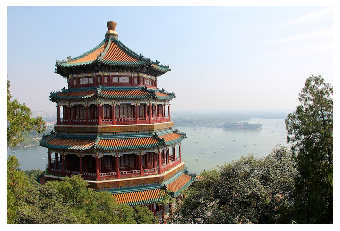

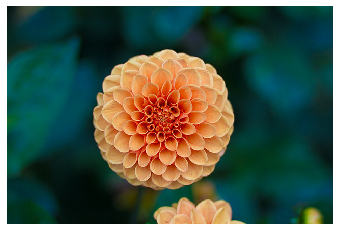

In [60]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

plot_color_image(images[0])
plt.show()
plot_color_image(images[1])
plt.show()

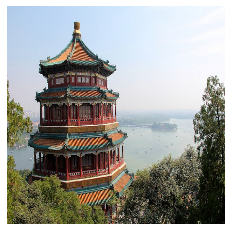

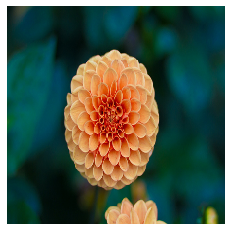

In [58]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

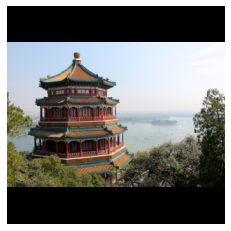

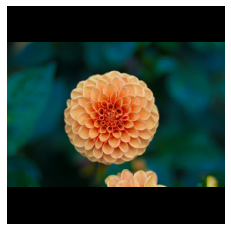

In [57]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

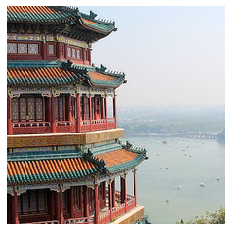

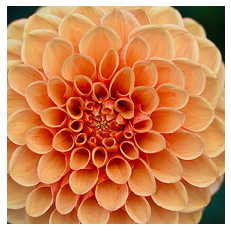

In [56]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

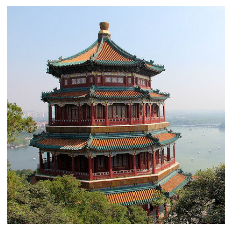

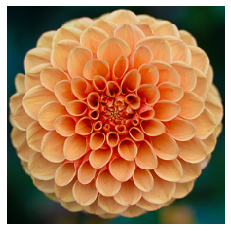

In [53]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

## ResNet-50

In [42]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 4s 0us/step


In [61]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [62]:
Y_proba.shape

(2, 1000)

In [63]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

Image #1
  n03530642 - honeycomb    49.83%
  n13040303 - stinkhorn    33.95%
  n02206856 - bee          4.35%



# Transfer Learning

In [64]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [66]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [68]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [69]:
n_classes = info.features['label'].num_classes
n_classes

5

In [71]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

In [72]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

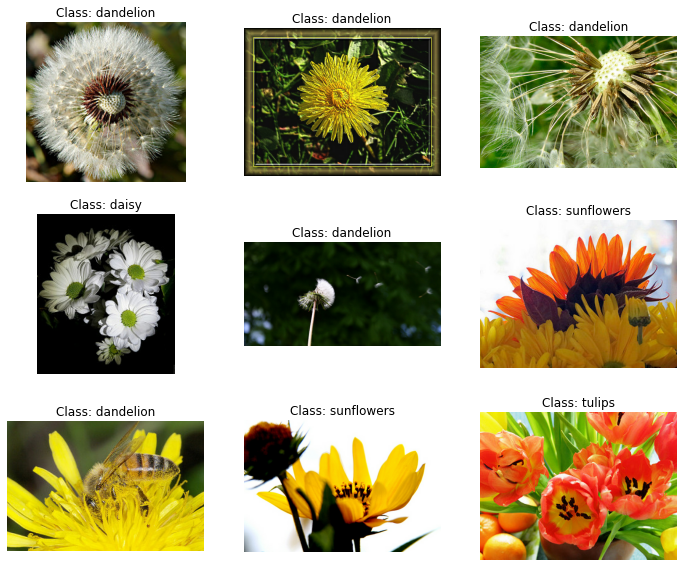

In [82]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [75]:
# Basic preprocessing necessary for training the network

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [76]:
# Fancier preprocessing

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

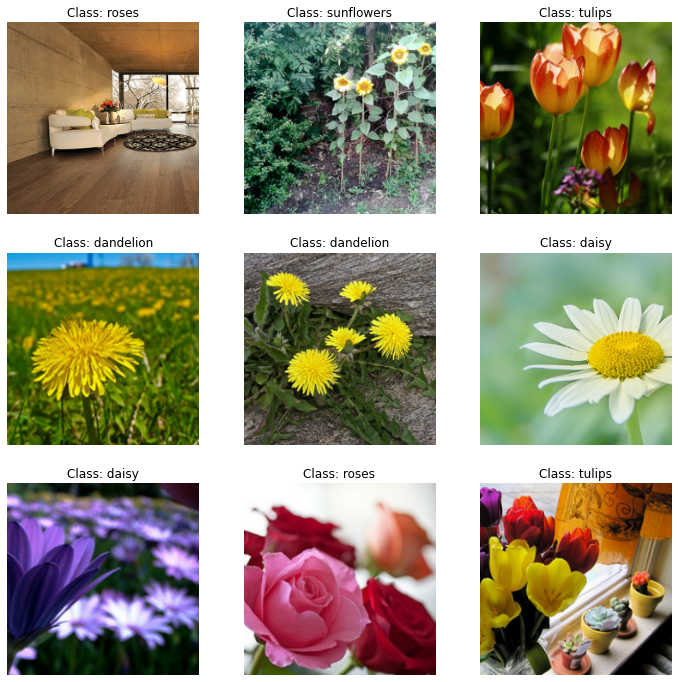

In [84]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

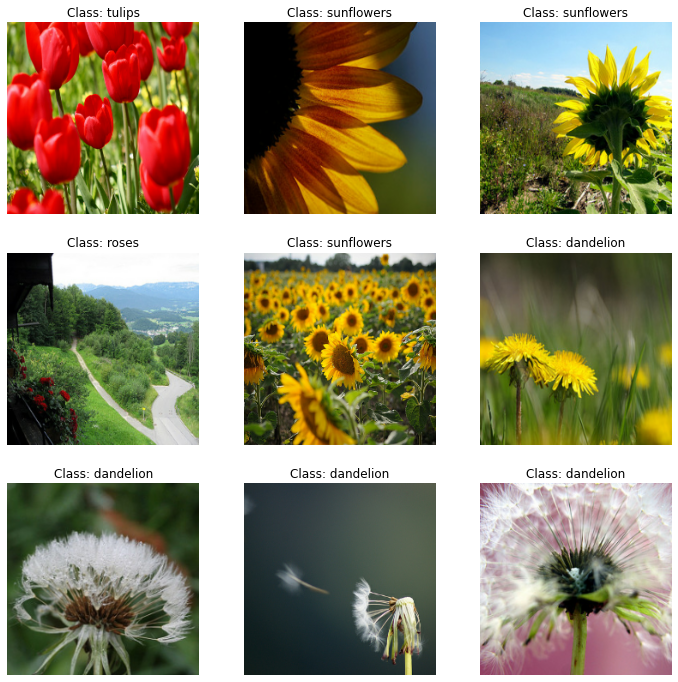

In [85]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [86]:
base_model = keras.applications.xception.Xception(weights='imagenet', 
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 0s 0us/step


In [87]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_6
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_141
13 block2_pool
14 batch_normalization_7
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_142
23 block3_pool
24 batch_normalization_8
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_143
33 block4_pool
34 batch_normalization_9
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

 Freezing the weights of the pretrained layers

In [90]:
# The model uses the base_model's layers directly (rather than the base_model object itself)
# setting   base_model.trainable=False   would have no effect

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 20s 179ms/step - loss: 1.6199 - accuracy: 0.7863 - val_loss: 1.3395 - val_accuracy: 0.8603
Epoch 2/5
86/86 [==============================] - 13s 149ms/step - loss: 0.6449 - accuracy: 0.9012 - val_loss: 0.9809 - val_accuracy: 0.8732
Epoch 3/5
86/86 [==============================] - 13s 148ms/step - loss: 0.3526 - accuracy: 0.9222 - val_loss: 0.9915 - val_accuracy: 0.8585
Epoch 4/5
86/86 [==============================] - 13s 155ms/step - loss: 0.3237 - accuracy: 0.9259 - val_loss: 0.9357 - val_accuracy: 0.8695
Epoch 5/5
86/86 [==============================] - 13s 151ms/step - loss: 0.2431 - accuracy: 0.9433 - val_loss: 0.7303 - val_accuracy: 0.8750


Unfreezing the pretrained layers  
Is necessary to re-compile the model

In [91]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

Epoch 1/20
86/86 [==============================] - 62s 619ms/step - loss: 0.3627 - accuracy: 0.8830 - val_loss: 0.3404 - val_accuracy: 0.8952
Epoch 2/20
86/86 [==============================] - 52s 601ms/step - loss: 0.1171 - accuracy: 0.9564 - val_loss: 0.4167 - val_accuracy: 0.8952
Epoch 3/20
86/86 [==============================] - 53s 615ms/step - loss: 0.0720 - accuracy: 0.9775 - val_loss: 0.2636 - val_accuracy: 0.9136
Epoch 4/20
86/86 [==============================] - 53s 618ms/step - loss: 0.0565 - accuracy: 0.9833 - val_loss: 0.3038 - val_accuracy: 0.9081
Epoch 5/20
86/86 [==============================] - 53s 617ms/step - loss: 0.0320 - accuracy: 0.9916 - val_loss: 0.2437 - val_accuracy: 0.9320
Epoch 6/20
86/86 [==============================] - 53s 620ms/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.2287 - val_accuracy: 0.9320
Epoch 7/20
86/86 [==============================] - 53s 615ms/step - loss: 0.0254 - accuracy: 0.9927 - val_loss: 0.3036 - val_accuracy: 0.9191

In [95]:
model.evaluate(test_set)

12/12 [==============================] - 2s 186ms/step - loss: 0.2160 - accuracy: 0.9428


[0.21599973738193512, 0.9427793025970459]

# Classification and Localization idea

In [99]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss=['sparse_categorical_crossentropy', 'mse'],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=['accuracy'])

In [100]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [101]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 7s 562ms/step - loss: 1.3433 - dense_22_loss: 1.5918 - dense_23_loss: 0.3492 - dense_22_accuracy: 0.3187 - dense_23_accuracy: 0.2812
Epoch 2/2
5/5 [==============================] - 3s 565ms/step - loss: 1.1041 - dense_22_loss: 1.3310 - dense_23_loss: 0.1964 - dense_22_accuracy: 0.5063 - dense_23_accuracy: 0.2688
